In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import time


In [2]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print(use_cuda)

False


In [3]:
pd.set_option('display.max_rows', None)
train_csv = pd.read_csv("train.csv")
test_csv = pd.read_csv("test.csv")
samples_submission_csv = pd.read_csv("sample_submission.csv")

In [30]:
dtf_description = train_csv.describe()
dtf_description

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [54]:
# use mean and column to replace the NA or field that are NAN instead to put thm to 0
dtf_description.loc['mean']['LotFrontage']

70.04995836802665

In [5]:
train_csv.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [6]:
def split_train_valid_data(data, perc=0.7):
    return data.head(int(len(data)*(perc)))
    


In [64]:
class CustomDataset(Dataset):
    def __init__(self, csv_file_data, csv_file_test, id_col, target_col, data='train'):
        self.data_train= pd.read_csv(csv_file_data)
        self.data_test = pd.read_csv(csv_file_test)
        self.id        = id_col
        self.target    = target_col
        self.data = data

    def __len__(self):
        if self.data == 'train':
            return len(self.data_train)
        else:
            return len(self.data_test)

    def __getitem__(self, idx):
        # remove the target column
        train_wo_SP = self.data_train.drop(self.target, axis='columns')
        # concat train and test features to have the same number of columns one the dummies features appear
        all_features = pd.concat([train_wo_SP, self.data_test], keys=["train", "test"])
        # Normalize the numerical features
        numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
        all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
        # creathe the dummies for train and test set
        all_features_dummies = pd.get_dummies(all_features)
        all_features_dummies = all_features_dummies.fillna(0)
        #print(all_features_dummies)
        
        # creation of the label of train dataset
        train_label1 = train_csv['Id']
        train_label2 = train_csv['SalePrice']
        train_label = pd.DataFrame(columns = ['Id', 'SalePrice'])
        train_label['Id'] = train_label1
        train_label['SalePrice'] = train_label2

        #Split Data - creation of the Validation dataset
        train_data = split_train_valid_data(all_features_dummies.loc['train'])
        valid_data = all_features_dummies.loc['train'].iloc[max(train_data.index+1):]
        
        #Split label - creation of the validation labelset
        label_train = split_train_valid_data(train_label)
        label_valid = train_label.iloc[max(train_data.index+1):]
         
        # creation of the test data set
        test_data = all_features_dummies.loc['test']
        
        # creation of an Empty label test
        label_test = pd.DataFrame(np.empty((test_data.shape[0],1)))
        
        train_data = train_data.astype(np.float32)
        valid_data = valid_data.astype(np.float32)
        test_data = test_data.astype(np.float32)
        
        # remove 'ID' columns - data
        train_data = train_data.drop(['Id'], axis=1)
        valid_data = valid_data.drop(['Id'],axis=1)
        test_data = test_data.drop(['Id'], axis=1)
        
        # remove 'ID' column - label
        label_train = label_train.drop(['Id'], axis=1)
        label_valid = label_valid.drop(['Id'], axis=1)
            
        # data preparation
        if self.data == 'train':
            use_data = train_data.to_numpy()
            use_data = torch.from_numpy(use_data)
        elif self.data == 'valid':
            use_data = valid_data.to_numpy()
            use_data = torch.from_numpy(use_data)
        elif self.data == 'test':
            use_data = test_data.to_numpy()
            use_data = torch.from_numpy(use_data)
            
        # label preparation
        if self.data == 'train':
            label_data = label_train.to_numpy()
            label_data = torch.from_numpy(label_data)
        elif self.data == 'valid':
            label_data = label_valid.to_numpy()
            label_data = torch.from_numpy(label_data)
        elif self.data == 'test':
            label_data = label_test.to_numpy()
            label_data = torch.from_numpy(label_data)
        
        return use_data, label_data

params = {
    'id_col':'Id',  
    'target_col': ['SalePrice'],
}

In [65]:
data_dataset = {x: CustomDataset(csv_file_data="train.csv" , 
                                   csv_file_test="test.csv", 
                                   **params, 
                                   data='train' if x == 'train'
                                   else 'valid' if x =='valid'
                                   else 'test')
                for x in ['train', 'valid', 'test']}

data_loader = {x: torch.utils.data.DataLoader(data_dataset[x], batch_size = 10,  shuffle=False) 
               for x in ['train', 'valid', 'test']}

In [79]:
tensor_dt = data_dataset['train'].__getitem__(1)
print(len(tensor_dt[0][0]))

print(type(tensor_dt))

288
<class 'tuple'>


In [80]:
print('TRAINING')

img, lab_target = data_dataset['train'].__getitem__(0)

print('DATASET')
print('image at the first row: ', img.shape)
print('image at the first row: ', type(img))
print('image size at the first row: {}'.format(img.size()))
print('\nTarget at the first row: ', lab_target)
print('Target format at the first row: {}'.format(lab_target))
print('Target format at the first row: {}'.format(lab_target.shape))


print()
print('Train Loader type')
train_iter = iter(data_loader['train'])
print(type(train_iter))

images, labels_target = train_iter.next()
print()
print('DATALOADER')
print('images type on batch size = {}'.format(type(images)))
print('images shape on batch size = ', images.shape)
print('\nTargett type on batch size')
print('Target type on batch size = {}'.format(type(labels_target)))
print('Target shape on batch size = ', labels_target.shape)

TRAINING
DATASET
image at the first row:  torch.Size([1021, 288])
image at the first row:  <class 'torch.Tensor'>
image size at the first row: torch.Size([1021, 288])

Target at the first row:  tensor([[208500],
        [181500],
        [223500],
        ...,
        [160000],
        [213490],
        [176000]])
Target format at the first row: tensor([[208500],
        [181500],
        [223500],
        ...,
        [160000],
        [213490],
        [176000]])
Target format at the first row: torch.Size([1021, 1])

Train Loader type
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>

DATALOADER
images type on batch size = <class 'torch.Tensor'>
images shape on batch size =  torch.Size([10, 1021, 288])

Targett type on batch size
Target type on batch size = <class 'torch.Tensor'>
Target shape on batch size =  torch.Size([10, 1021, 1])


In [12]:
for idx, (data, target) in enumerate(data_loader['train']):
    print(len(target))
    next

10
10
10
10
10
10
10
10
10


KeyboardInterrupt: 

'Model creation

In [14]:
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        # linear layer (330 -> 755001)
        self.fc1 = nn.Linear(288, 250)
        
        # linear layer (500 -> 250)
        self.fc2 = nn.Linear(250, 125)
        
        # linear layer (250 -> 125)
        self.fc3 = nn.Linear(125, 75)
        
        # linear layer (125 -> 1)
        self.fc4 = nn.Linear(75, 755001)
        
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.175)
        
        # LogSoftmax
        self.LSM = nn.LogSoftmax()
    
    def forward(self, x):
        
        # add 1st hidden layer, with relu activation function
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        #h2
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        #h3
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        #h4
        x = self.fc4(x)
        x = self.LSM(x)

        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_HR = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_patho.cuda()

In [15]:
model_HR

Net(
  (fc1): Linear(in_features=288, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=125, bias=True)
  (fc3): Linear(in_features=125, out_features=75, bias=True)
  (fc4): Linear(in_features=75, out_features=755001, bias=True)
  (dropout): Dropout(p=0.175, inplace=False)
  (LSM): LogSoftmax()
)

In [16]:
### TODO: select loss function
criterion = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer = optim.SGD(model_HR.parameters(), lr=0.01, momentum = 0.9)

VERSION = 'Test_version'

In [17]:
def train(n_epochs, loaders, model, optimizer, criterion):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    time_start = time.time()
    train_class = []
    valid_class = []
    epoch_class = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        LR = 0.01
        
        ###################
        # train the model #
        ###################
        model.train()
        for idx, (data, target) in enumerate(loaders['train']):
            
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()

            output = model(data)
            
            loss = criterion(output, target.squeeze(-1))
            
            loss.backward()
            
            optimizer.step()

            train_loss += loss.item()*data.size(0)
            
        model.eval()
        for idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target.squeeze(-1))
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].sampler)
        
        
        valid_loss = valid_loss/len(loaders['valid'].sampler)
        
        if valid_loss < 0.35 and valid_loss > 0.15:
            LR=0.005
        elif valid_loss < 0.15:
            LR=0.001
        
        
        # Calcul time
        time_now = time.time()
        
        time_epoch = (time_now - time_start)/60
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTime since the beginning {:.1f} min \tLearning rate: {:.6f} '.format(
            epoch, 
            train_loss,
            valid_loss,
            time_epoch,
            LR
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss,
            torch.save(model.state_dict(), VERSION))
                 )
            valid_loss_min = valid_loss
        
        # store class data
        train_class.append(train_loss)
        valid_class.append(valid_loss)
        epoch_class.append(epoch)
    
    plt.plot(epoch_class, train_class, 'g', label='Training loss')
    plt.plot(epoch_class, valid_class, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # return trained model
    return model

C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 	Training Loss: 13.522294 	Validation Loss: 13.504157 	Time since the beginning 1.8 min 	Learning rate: 0.010000 
Validation loss decreased (inf --> 13.504157).  Saving model ...
Epoch: 2 	Training Loss: 13.351097 	Validation Loss: 12.840249 	Time since the beginning 3.6 min 	Learning rate: 0.010000 
Validation loss decreased (13.504157 --> 12.840249).  Saving model ...
Epoch: 3 	Training Loss: 11.050257 	Validation Loss: 10.242091 	Time since the beginning 5.4 min 	Learning rate: 0.010000 
Validation loss decreased (12.840249 --> 10.242091).  Saving model ...
Epoch: 4 	Training Loss: 8.973546 	Validation Loss: 9.621675 	Time since the beginning 7.1 min 	Learning rate: 0.010000 
Validation loss decreased (10.242091 --> 9.621675).  Saving model ...
Epoch: 5 	Training Loss: 8.022004 	Validation Loss: 9.274684 	Time since the beginning 8.8 min 	Learning rate: 0.010000 
Validation loss decreased (9.621675 --> 9.274684).  Saving model ...
Epoch: 6 	Training Loss: 7.492919 	Validati

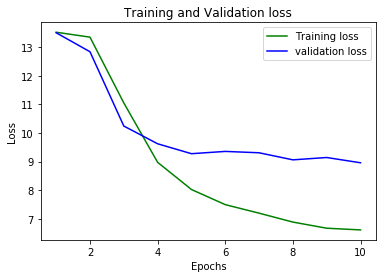

In [18]:
model_res = train(10, data_loader, model_HR, optimizer, criterion)

In [19]:
def train2(n_epochs, loaders, model, optimizer, criterion):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    time_start = time.time()
    train_class = []
    valid_class = []
    epoch_class = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        LR = 0.01
        
        ###################
        # train the model #
        ###################
        model.train()
        for idx, (data, target) in enumerate(loaders['train']):
            
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()

            output = model(data)
            
            loss = criterion(output, target.squeeze(-1))
            
            loss.backward()
            
            optimizer.step()

            train_loss += loss.item()*data.size(0)
            
        model.eval()
        for idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target.squeeze(-1))
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].sampler)
        
        
        valid_loss = valid_loss/len(loaders['valid'].sampler)
        
        if valid_loss < 0.35 and valid_loss > 0.15:
            LR=0.005
        elif valid_loss < 0.15:
            LR=0.001
        
        
        # Calcul time
        time_now = time.time()
        
        time_epoch = (time_now - time_start)/60
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTime since the beginning {:.1f} min \tLearning rate: {:.6f} '.format(
            epoch, 
            train_loss,
            valid_loss,
            time_epoch,
            LR
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss,
            torch.save(model.state_dict(), VERSION))
                 )
            valid_loss_min = valid_loss
        
        # store class data
        train_class.append(train_loss)
        valid_class.append(valid_loss)
        epoch_class.append(epoch)
    
    plt.plot(epoch_class, train_class, 'g', label='Training loss')
    plt.plot(epoch_class, valid_class, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # return trained model
    return model

In [20]:
model_res = train(10, data_loader2, model_HR, optimizer, criterion)

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 30834240840 bytes. Buy new RAM!


In [ ]:
# test


In [ ]:
dataiter_test = iter(data_loader['test'])
print('data_iter\n',dataiter_test)
data_test = dataiter_test.next()
data_test_data = data_test[0]
print('image test data',data_test_data)

model_test = model_HR
model_test.load_state_dict(torch.load(VERSION))
model_test = model_test.eval()


out_fwd = model_test.forward(data_test_data)
print('Result preditcion model on dataset:\n {}\n'.format(out_fwd))
probs = torch.exp(out_fwd)
print('probs\n', probs)
print(probs.max())
print(probs.min())